# Image Classification (Cats vs Dogs)
**Author:** *Mahdi Rafati (mehdirt)*

----

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from utils.train import train_model
from utils.data_utils import *
from utils.model_utils import *
from utils.predict_utils import *
from utils.vis_utils import *

# Some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
use_gpu

False

## Data

In [3]:
DATA_DIR = "data/"
os.listdir(DATA_DIR)

['train', 'test', 'val']

In [19]:
trn_dir = f"{DATA_DIR}train"
val_dir = f"{DATA_DIR}val"

os.listdir(trn_dir)

['white',
 'blue',
 'pink',
 'yellow',
 'brown',
 'purple',
 'red',
 'grey',
 'beige',
 'silver',
 'orange',
 'green',
 'gold',
 'tan',
 'black']

In [5]:
trn_fnames = glob.glob(f"{trn_dir}/*/*.jpg")
trn_fnames[:5]

['data/train/white/517071ce0d.jpg',
 'data/train/white/2914a67735.jpg',
 'data/train/white/c1eb71e863.jpg',
 'data/train/white/c3c6f06e75.jpg',
 'data/train/white/7e55606a95.jpg']

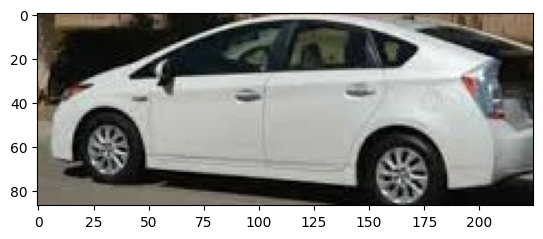

In [6]:
img = plt.imread(trn_fnames[15])
plt.imshow(img)

## Datasets and DataLoaders in Pytorch

In [9]:
train_ds = datasets.ImageFolder(trn_dir)
train_ds.classes

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

In [12]:
print(train_ds.class_to_idx, train_ds.root, sep='\n')

{'beige': 0, 'black': 1, 'blue': 2, 'brown': 3, 'gold': 4, 'green': 5, 'grey': 6, 'orange': 7, 'pink': 8, 'purple': 9, 'red': 10, 'silver': 11, 'tan': 12, 'white': 13, 'yellow': 14}
data/train


In [15]:
train_ds.imgs[:10]

[('data/train/beige/00ecfeedea.jpg', 0),
 ('data/train/beige/012d5b3f87.jpg', 0),
 ('data/train/beige/02373872da.jpg', 0),
 ('data/train/beige/02c2e8bbc2.jpg', 0),
 ('data/train/beige/047c3235ad.jpg', 0),
 ('data/train/beige/04ee8952e9.jpg', 0),
 ('data/train/beige/05c8a236ac.jpg', 0),
 ('data/train/beige/0657543685.jpg', 0),
 ('data/train/beige/067ead93fc.jpg', 0),
 ('data/train/beige/06b9d192ff.jpg', 0)]

In [16]:
type(train_ds.transform)

NoneType

### Transformations

DataLoader object uses these transformations when loading data:

In [24]:
size = 224
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
tfms = transforms.Compose([
    transforms.Resize((size, size)), # PIL Image
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [21]:
len(train_ds), len(valid_ds)

(7267, 1550)

### DataLoaders

In [22]:
train_dl = DataLoader(train_ds,
                     batch_size=batch_size,
                     shuffle=True,
                     num_workers=4)

valid_dl = DataLoader(valid_ds,
                     batch_size=batch_size,
                     shuffle=False,
                     num_workers=4)

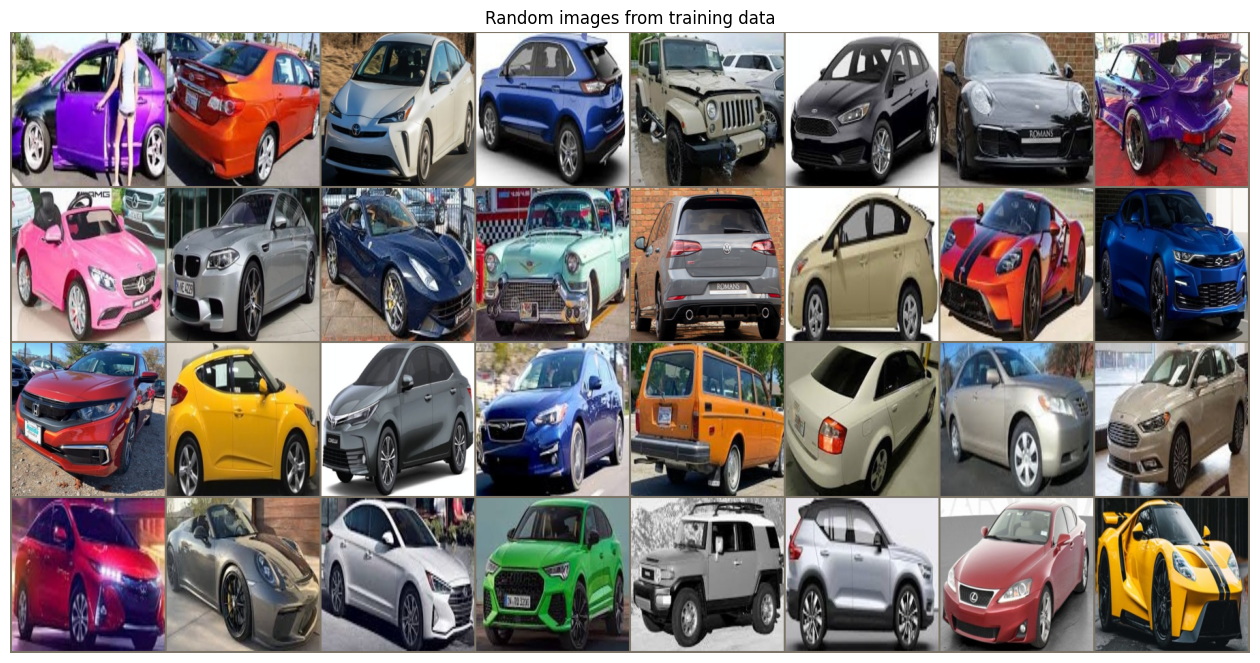

In [23]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title="Random images from training data")

## Transfer Learning

- Use a CNN already trained on different data (e.g. ImageNet)

- Just train the classifier weights (Last layer)

In [28]:
# Load pre-trained ResNet34
model = load_pretrained_resnet18(model_path=None, num_classes=15)
model = model.to(device)

### Loss Function and Optimizer

In [ ]:
# loss and optmizer
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [ ]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=num_epochs)

Epoch 1/10
----------


  train Loss: 0.94179 Acc: 0.69602
  valid Loss: 0.50845 Acc: 0.82065

Epoch 2/10
----------
  Step 131/227 | Loss: 0.43957

## Analyze Results

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval() 
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    print(f"Accuracy: {100 * corrects / len(dataloader.dataset):.2f}")

### Accuracy on Validation Data

In [1]:
evaluate_model(model, valid_dl, device)

NameError: name 'evaluate_model' is not defined

### Accuracy on Training Data

In [2]:
evaluate_model(model, train_dl, device)

NameError: name 'evaluate_model' is not defined

In [3]:
visualize_model(model, train_dl, device)

NameError: name 'visualize_model' is not defined

In [4]:
plot_errors(model, valid_dl, device)

NameError: name 'plot_errors' is not defined

### Confusion Matrix

In [8]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

NameError: name 'predict_class' is not defined

## Export the model to ONXX format

In [ ]:
# Load trained weights
model.load_state_dict(torch.load("color_model_weights.pth"))
# Set to infrenece mode
model.eval()

In [ ]:
# Create a random input (adjust shape to your model's input size)
random_input = torch.randn(1, 3, 224, 224)  # (batch_size, channels, height, width)

# Export to ONNX
onnx_program = torch.onnx.export(
    model,                                   # PyTorch model
    random_input,                             # Random input
    input_names=["input"],                   # Input tensor name
    output_names=["output"],                 # Output tensor name
    opset_version=12,                         # ONNX operator set version
)

# Save the ONNX model in a file
onnx_program.save("models/color_classifire.onnx")

### Check ONNX model 

In [ ]:
import onnx

onnx_model = onnx.load("models/color_classifire.onnx")
onnx.checker.check_model(onnx_model)

## Overfit

In case that the model is still overfitting, we turn to data augmentation.

### Data Augmentation

In [5]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{DATA_DIR}train", train_transforms)
valid_ds = datasets.ImageFolder(f"{DATA_DIR}valid", valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print(f"Train size: {train_ds_sz}\n Valid size: {valid_ds_sz} ({valid_ds_sz / (train_ds_sz + valid_ds_sz):.2f})")

class_names = train_ds.classes 

NameError: name 'transforms' is not defined

In [6]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title="Augmented Images")

NameError: name 'train_dl' is not defined

### Look at the sizes of images

In [7]:
fnames = glob.glob(f"{trn_dir}/*/*.jpg")
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12, 4))
plt.hist(hs, label="Hights", color='blue')
plt.hist(ws, label="Widths", color='orange')

NameError: name 'glob' is not defined